In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

$y=ax+b+\varepsilon$ ($\varepsilon$:ノイズ) に極端な外れ値がある場合の $a, b$ の推定

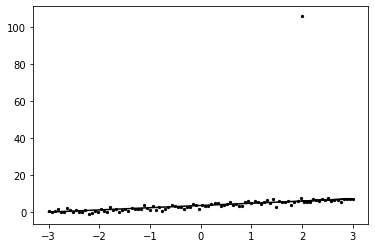

In [2]:
a_true = 1.2
b_true = 3.4
size=100

np.random.seed(42)
X = np.array([*np.linspace(-3, 3, size), 2])
Y = a_true * X + b_true + np.array([np.random.normal(0, 1) for _ in range(size)]+[100])

plt.scatter(X, Y, c='k', s=5)
plt.plot(X, a_true*X+b_true, color='k')

In [3]:
class MH_sampler(object):
    def __init__(self, X, Y, p=2, eps=(0.1, 0.1), random_state=None):
        self.p = p
        self.eps = eps
        self.random_state = random_state
        self.random = np.random
        self.random.seed(random_state)
        self.X = X
        self.Y = Y
    
    def logLikelihood(self, a, b, p=2, length_factor=1):
        if p==0: return -(np.abs(self.Y - (a * self.X + b))>1e-1).sum() - (a-1.2)**2/2 - (b-3.4)**2/2
        elif p==-1: return -(np.abs(self.Y - (a * self.X + b))>1e-2).sum() + self.logLikelihood(a, b, p=1)
        elif p==-2: return -(np.abs(self.Y - (a * self.X + b))>1e-2).sum() + self.logLikelihood(a, b, p=1)*0.1
        return (-(np.abs(self.Y - (a * self.X + b))/length_factor)**p/p - np.log(length_factor)).sum()

    def sampling(self, samplesize=10**4):
        pre_param = (0, 0)
        samples = [pre_param]
        accepts = [False]
        pre_ll = self.logLikelihood(*pre_param, p=self.p)
        for i in range(1, samplesize):
            a,b = pre_param
            if i%2==0:
                a += self.eps[0] * self.random.normal(0, 1)
            else:
                b += self.eps[1] * self.random.normal(0, 1)
            new_ll = self.logLikelihood(a, b, p=self.p)
            if new_ll>=pre_ll or self.random.rand() <= np.exp(-pre_ll+new_ll):
                accepts += [True]
                pre_param = (a, b)
                pre_ll = new_ll
            else:
                accepts += [False]
            samples += [pre_param]
        self.samples = np.array(samples)
        self.accepts = np.array(accepts)
        return self.samples

In [4]:
def eps_adjust(X, Y, p):
    model = MH_sampler(X, Y, p, eps=(0.01, 0.01))
    model.sampling()
    ac1 = model.accepts
    model = MH_sampler(X, Y, p, eps=(0.1, 0.1))
    model.sampling()
    ac2 = model.accepts
    model = MH_sampler(X, Y, p, eps=(1, 1))
    model.sampling()
    ac3 = model.accepts
    for i in [0,1]:
        plt.plot([0.01, 0.1, 1], 
                 [a[i::2].sum() / a[i::2].size for a in [ac1,ac2,ac3]],
                 marker='o')
        plt.axhline(0.5, color='k')
        plt.title("ab"[i])
        plt.xscale('log')
        plt.ylim(0,1)
        plt.show()

In [5]:
def plot_chains(models, rng=slice(None,None,None)):
    for k in range(3):
        plt.plot(models[k].samples[rng,0], alpha=0.5)
    plt.xlabel('samples')
    plt.ylabel(r"$a$")
    plt.show()
    for k in range(3):
        plt.plot(models[k].samples[rng,1], alpha=0.5)
    plt.xlabel('samples')
    plt.ylabel(r"$b$")
    plt.show()

In [6]:
def plot_hist(models, burnin=10**4, step=10):
    for k in range(3):
        plt.hist(models[k].samples[burnin::step,0], bins='auto', alpha=0.5, histtype="step", density=True)
    plt.xlabel(r"$a$")
    plt.ylabel('probability density')
    plt.show()
    for k in range(3):
        plt.hist(models[k].samples[burnin::step,1], bins='auto', alpha=0.5 ,histtype="step", density=True)
    plt.xlabel(r"$a$")
    plt.ylabel('probability density')
    plt.show()

In [7]:
def show_prediction(models, ylim=(-2,9),
                    burnin=10**4, step=10, CIrate=95):
    a_smp = np.concatenate([model.samples[burnin::step,0] for model in models])
    b_smp = np.concatenate([model.samples[burnin::step,1] for model in models])

    plt.scatter(X, Y, c='k', s=5)
    X_lin = np.linspace(-3,3,100)
    plt.plot(X_lin, a_true*X_lin+b_true, color='k')

    y_pred = X_lin[:, np.newaxis] @ a_smp[np.newaxis, :] + b_smp
    plt.plot(X_lin, np.percentile(y_pred, 50, axis=1), color='C0')
    plt.fill_between(
        X_lin,
        np.percentile(y_pred, (100-CIrate)/2, axis=1),
        np.percentile(y_pred, 100-(100-CIrate)/2, axis=1),
        color='C0', alpha=0.5)

    plt.ylim(*ylim)

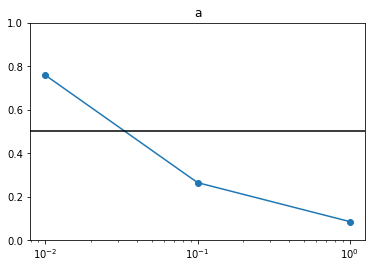

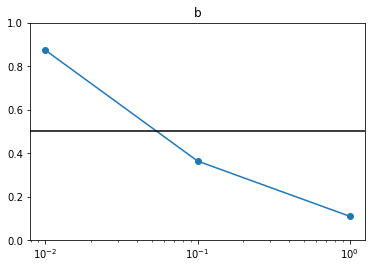

In [8]:
eps_adjust(X, Y, 0)

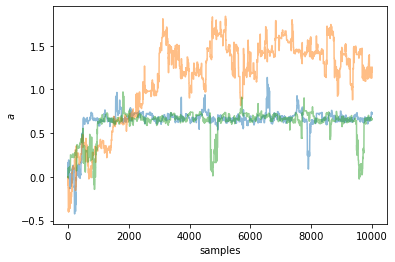

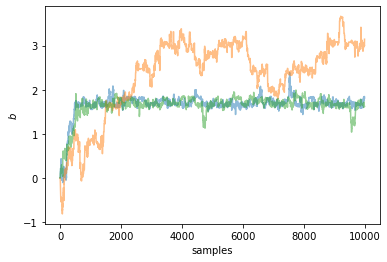

In [9]:
models = [MH_sampler(X, Y, 0, eps=(0.1, 0.1)) for _ in range(3)]
for k in range(3):
    models[k].sampling(10**5)
    
plot_chains(models, slice(0,10**4))

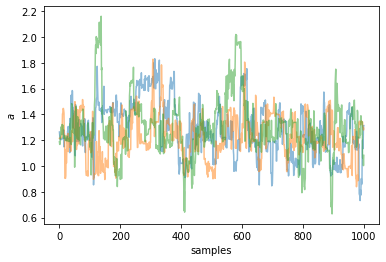

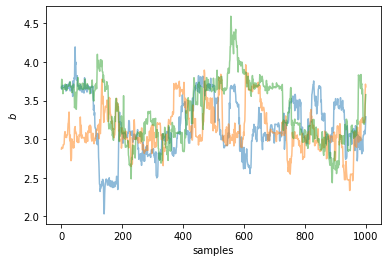

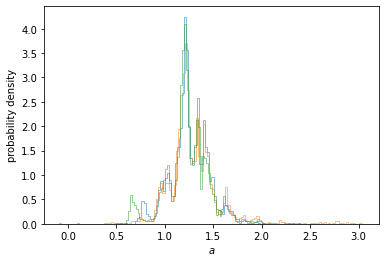

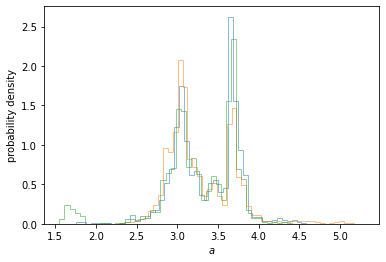

In [10]:
plot_chains(models, slice(-10**4,None,10))

plot_hist(models, 10**4)

In [11]:
for k in range(3):
    models[k].sampling(10**6)

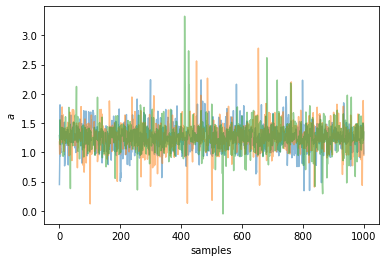

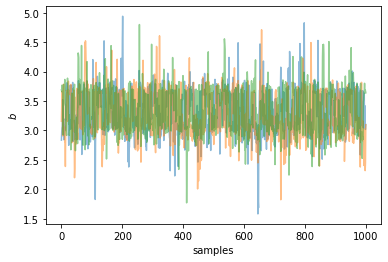

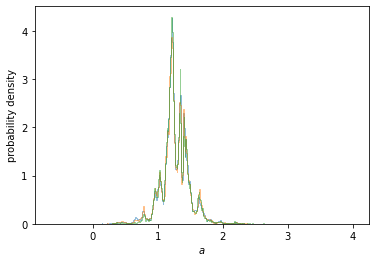

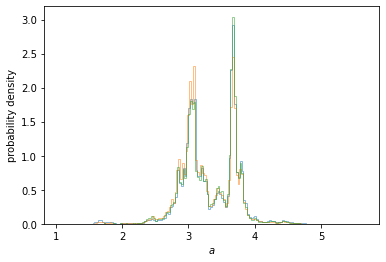

In [12]:
plot_chains(models, slice(-5*10**5,None,500))

plot_hist(models, 10**4)

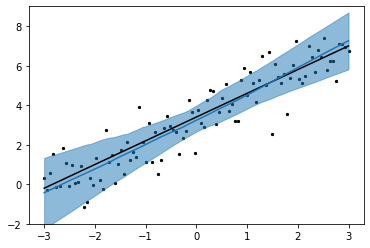

In [13]:
show_prediction(models, burnin=5*10**5, step=500)

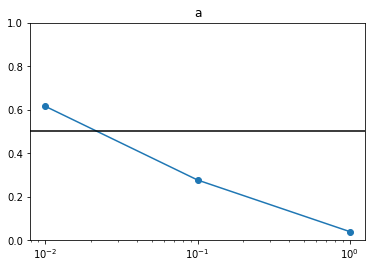

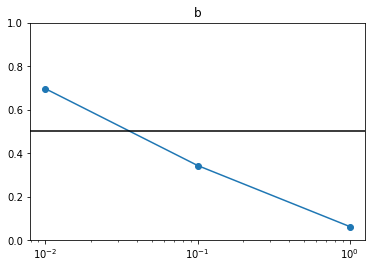

In [14]:
eps_adjust(X, Y, -1)

In [15]:
models = [MH_sampler(X, Y, -1, eps=(0.01, 0.01)) for _ in range(3)]
for k in range(3):
    models[k].sampling(10**5)

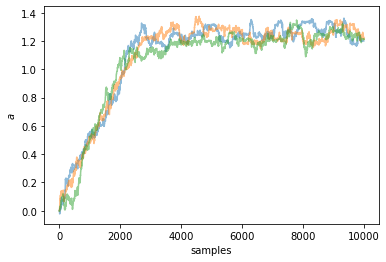

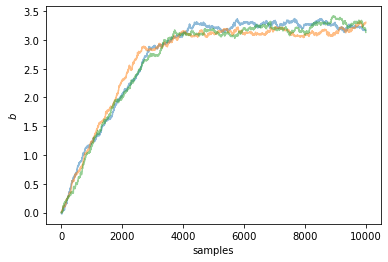

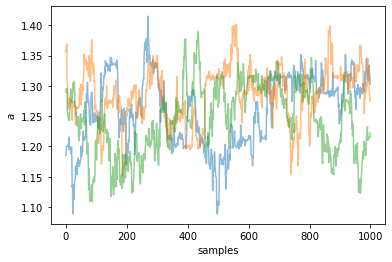

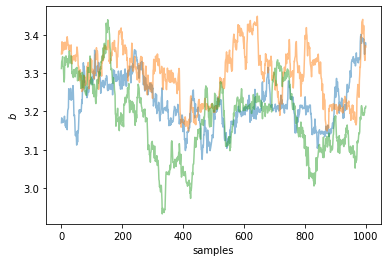

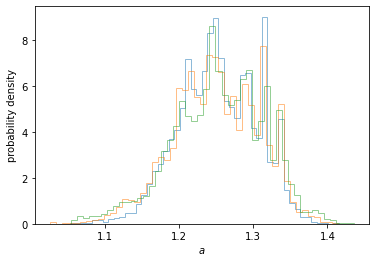

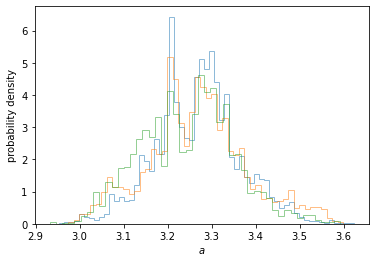

In [16]:
plot_chains(models, slice(0,10**4))

plot_chains(models, slice(-10**4,None,10))

plot_hist(models, 10**4)

In [17]:
for k in range(3):
    models[k].sampling(10**6)

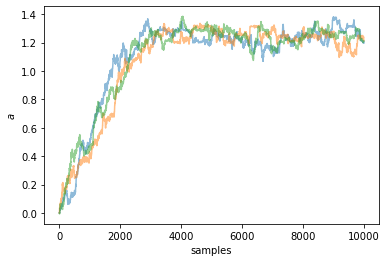

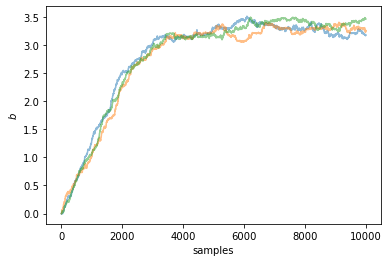

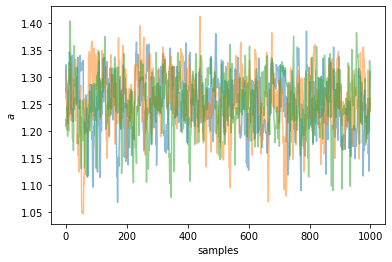

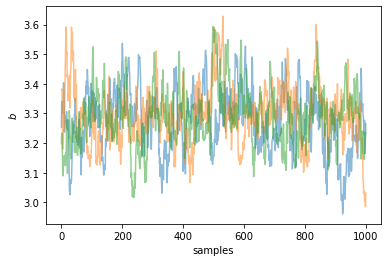

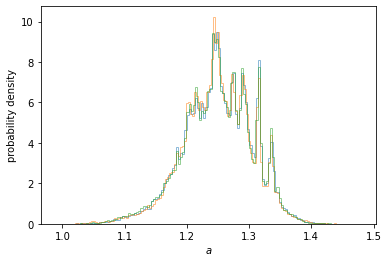

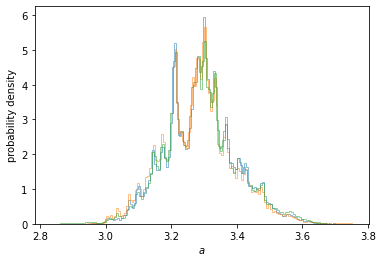

In [18]:
plot_chains(models, slice(0,10**4))

plot_chains(models, slice(-10**5,None,100))

plot_hist(models, 10**5)

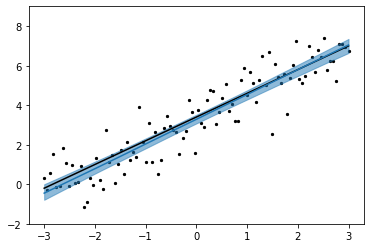

In [19]:
show_prediction(models)

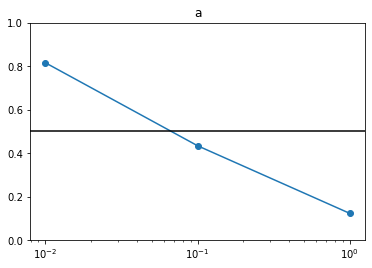

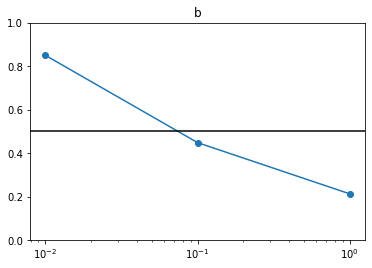

In [20]:
eps_adjust(X, Y, -2)

In [21]:
models = [MH_sampler(X, Y, -1, eps=(0.01, 0.01)) for _ in range(3)]
for k in range(3):
    models[k].sampling(10**5)

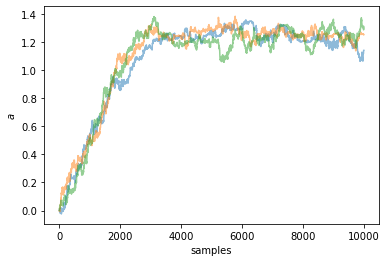

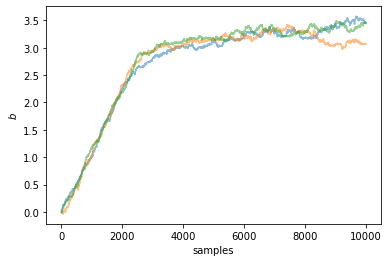

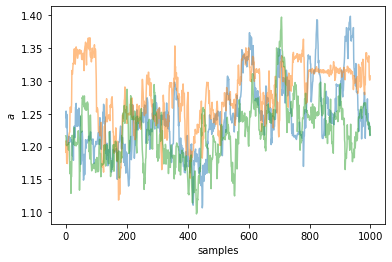

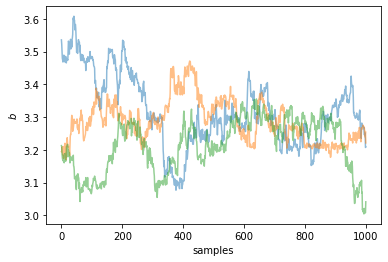

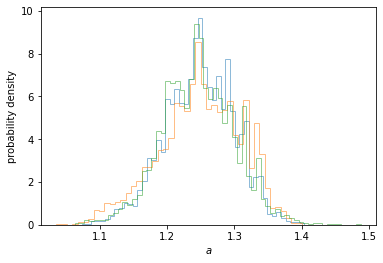

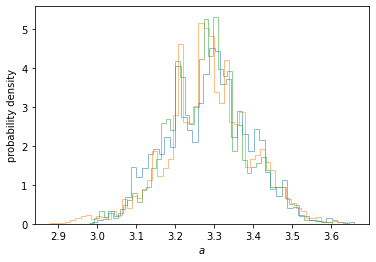

In [22]:
plot_chains(models, slice(0,10**4))

plot_chains(models, slice(-10**4,None,10))

plot_hist(models, 10**4)

In [53]:
for k in range(3):
    models[k].sampling(10**6)

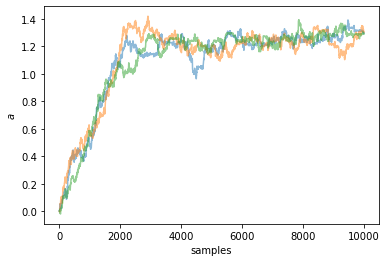

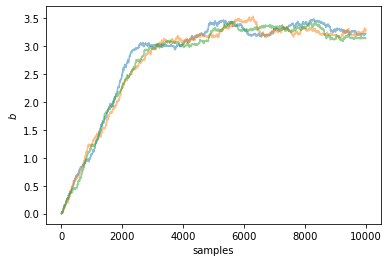

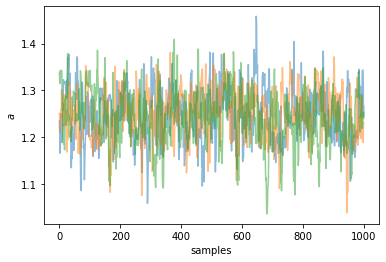

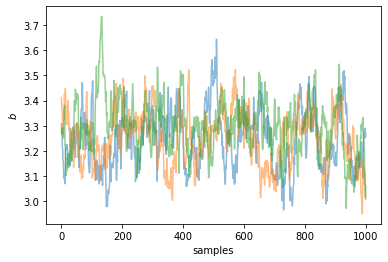

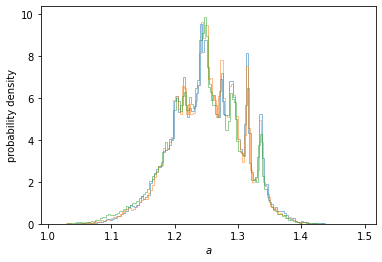

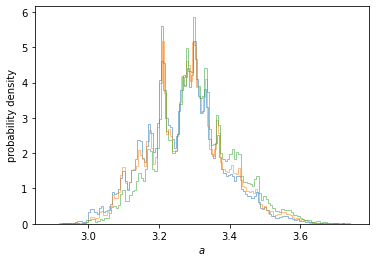

In [24]:
plot_chains(models, slice(0,10**4))

plot_chains(models, slice(-10**5,None,100))

plot_hist(models, 10**5)

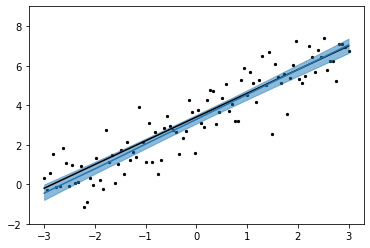

In [25]:
show_prediction(models)

In [33]:
np.histogram(
    models[0].samples[burnin::step,0], bins='auto')[0].shape

(134,)

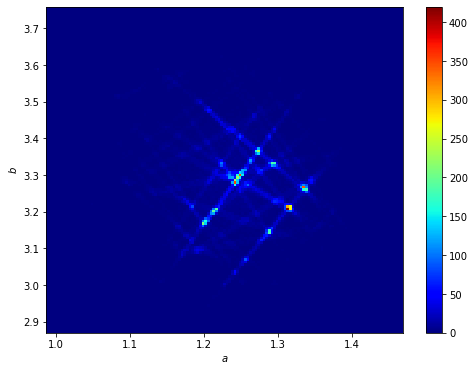

In [66]:
import matplotlib.cm as cm
burnin=10**4
step=10

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

H = ax.hist2d(
    np.concatenate([models[k].samples[burnin::step,0] for k in range(3)]),
    np.concatenate([models[k].samples[burnin::step,1] for k in range(3)]),
    density=True, bins=[135, 135], cmap=cm.jet, vmax=420)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.colorbar(H[3],ax=ax)
plt.show()

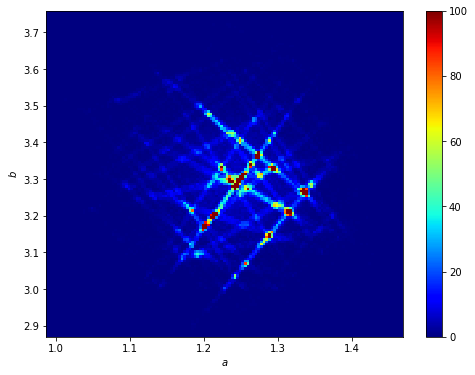

In [80]:
import matplotlib.cm as cm
burnin=10**4
step=10

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

H = ax.hist2d(
    np.concatenate([models[k].samples[burnin::step,0] for k in range(3)]),
    np.concatenate([models[k].samples[burnin::step,1] for k in range(3)]),
    density=True, bins=[135, 135], cmap=cm.jet, vmax=100)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.colorbar(H[3],ax=ax)
plt.show()

In [60]:
H[3]

In [61]:
models1 = [MH_sampler(X, Y, 1, eps=(0.1, 0.25)) for _ in range(3)]
for k in range(3):
    models1[k].sampling(10**5)

In [62]:
np.histogram(
    models1[0].samples[burnin::step,0], bins='auto')[0].shape

(60,)

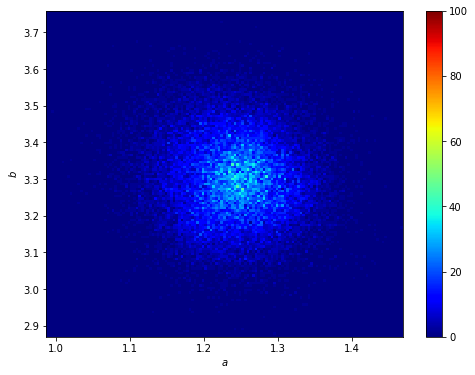

In [81]:
import matplotlib.cm as cm
burnin=10**4
step=10

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

H1 = ax.hist2d(
    np.concatenate([models1[k].samples[burnin::step,0] for k in range(3)]),
    np.concatenate([models1[k].samples[burnin::step,1] for k in range(3)]),
    density=True, bins=[H[1],H[2]], cmap=cm.jet, vmax=100)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.colorbar(H1[3],ax=ax)
plt.show()